In [2]:
import os
import numpy as np
import sys
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Reshape
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical

In [3]:
PATH = '/content/drive/MyDrive/AudioWAV/'

In [4]:
# Step 1: Create DataFrame with file paths and emotions
directory_list = os.listdir(PATH)

file_emotion = []
file_path = []

for file in directory_list:
    file_path.append(PATH + file)
    part = file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

In [5]:
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)
crema_df.to_csv("crema_df.csv", index=False)
print(crema_df.head())  # Display the first few rows of the DataFrame


  Emotions                                               Path
0  disgust  /content/drive/MyDrive/AudioWAV/1079_TIE_DIS_X...
1    happy  /content/drive/MyDrive/AudioWAV/1079_TIE_HAP_X...
2  neutral  /content/drive/MyDrive/AudioWAV/1079_WSI_NEU_X...
3     fear  /content/drive/MyDrive/AudioWAV/1079_WSI_FEA_X...
4    angry  /content/drive/MyDrive/AudioWAV/1079_TSI_ANG_X...


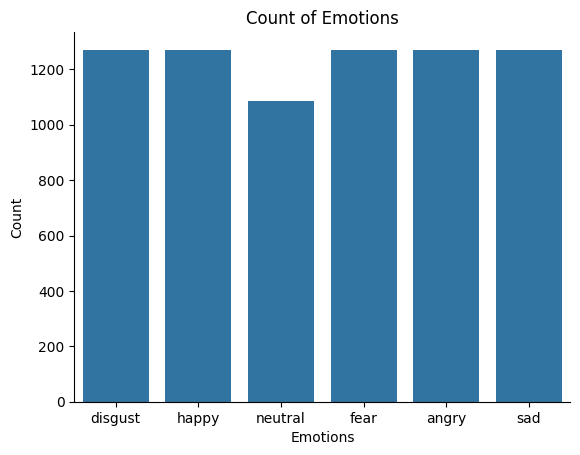

In [6]:
#Count of Emotions
plt.title('Count of Emotions')
sns.countplot(x = crema_df.Emotions)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [23]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, n_steps=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)
path = np.array(crema_df.Path)[1]
data, sample_rate = librosa.load(path)

In [24]:
def extract_features(data):
    result = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=20).T, axis=0)
    result = np.hstack((result, mfcc))

    # Additional features
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))

    # Harmonic-to-Noise Ratio (HNR)
    hnr = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, hnr))

    return result

def get_features(path):
    data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)

    res1 = extract_features(data)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))

    lowspeed_data = stretch(data, rate = 0.7)
    res3 = extract_features(lowspeed_data)
    result = np.vstack((result, res3))

    highspeed_data = stretch(data, rate = 1.25)
    res4 = extract_features(highspeed_data)
    result = np.vstack((result, res4))

    pitch_data = pitch(data, sample_rate, n_steps = 0.8)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    shift_data = shift(data)
    res6 = extract_features(shift_data)
    result = np.vstack((result, res6))

    return result

In [25]:
X, Y = [], []
for path, emotion in zip(crema_df.Path, crema_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [26]:
from concurrent.futures import ThreadPoolExecutor

def process_audio_file(path, emotion, X, Y):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)
    return (path, emotion)

if __name__ == "__main__":
    X, Y = [], []
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, emotion in zip(crema_df.Path, crema_df.Emotions):
            future = executor.submit(process_audio_file, path, emotion, X, Y)
            futures.append(future)

        for future in futures:
            path, emotion = future.result()

In [27]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('features.csv', index = False)
features.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,labels
0,-391.403351,137.468567,-0.414460,46.903652,-19.687508,22.560968,-19.923321,13.531672,-10.622375,7.332146,...,-10.968557,7.913958,-12.269460,3.506327,-9.307921,-2.512387,-0.656167,0.096560,0.014977,neutral
1,-293.830268,59.813140,26.111250,13.313392,4.955440,2.458985,-2.344540,1.348102,-0.684769,2.735689,...,-2.911822,-1.286670,-4.280061,-3.348865,-3.726168,-4.021437,-1.316403,0.182435,0.015475,neutral
2,-423.341095,130.657974,3.193319,41.197994,-16.222218,18.166931,-18.252106,10.937483,-9.085070,6.533459,...,-10.304187,7.081038,-11.003271,2.580742,-7.939143,-2.876927,0.251665,0.104594,0.010518,neutral
3,-417.876862,135.119965,-0.818793,42.184807,-16.355312,20.888918,-18.252794,11.481102,-10.520505,6.608838,...,-9.970866,8.031431,-11.223002,2.641624,-9.096037,-4.264453,-0.663581,0.092799,0.011174,neutral
4,-414.400879,129.420639,4.378838,35.489006,-15.442673,16.127428,-16.291025,12.687508,-11.371362,11.638647,...,-5.526564,4.177160,-12.523297,2.079585,-11.117249,2.008121,-2.785154,0.102601,0.011053,neutral


In [28]:
X = features.iloc[: ,: -1].values
Y = features['labels'].values

In [29]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()


In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 42, shuffle = True)

In [31]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [32]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

In [33]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Reshape

# Define input shape
input_shape = (x_train.shape[1], 1)

# Input Layer
inputs = Input(shape=input_shape)

# CNN Layers for feature extraction
x = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
x = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

x = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

x = Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu')(x)
x = Dropout(0.25)(x)
x = MaxPooling1D(pool_size=2, strides=2, padding='same')(x)

cnn_output_shape = x.shape  # Shape after CNN layers

# Reshape to fit into LSTM
timesteps = cnn_output_shape[1]
features = cnn_output_shape[2]
x = Reshape((timesteps, features))(x)  # Adjust to the actual output shape

# LSTM Layer to capture temporal relationships
x = LSTM(128, return_sequences=False)(x)

# Dense Layer for output
outputs = Dense(units=6, activation='softmax')(x)  # Adjust the number of units based on your output classes

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [34]:
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.4, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_model_weights.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
]

# Fit the model
history = model.fit(
    x_train, y_train,
    batch_size=64,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)


Epoch 1/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.3277 - loss: 1.5771 - val_accuracy: 0.4068 - val_loss: 1.4390 - learning_rate: 0.0010
Epoch 2/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.4144 - loss: 1.4261 - val_accuracy: 0.4211 - val_loss: 1.4027 - learning_rate: 0.0010
Epoch 3/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.4330 - loss: 1.3816 - val_accuracy: 0.4502 - val_loss: 1.3540 - learning_rate: 0.0010
Epoch 4/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4510 - loss: 1.3481 - val_accuracy: 0.4699 - val_loss: 1.3216 - learning_rate: 0.0010
Epoch 5/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.4678 - loss: 1.3102 - val_accuracy: 0.4837 - val_loss: 1.2849 - learning_rate: 0.0010
Epoch 6/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.4840 - loss: 1.2804 - val_accuracy: 0.5026 - val_loss: 1.2417 - learning_rate: 0.0010
Epoch 7/50
524/524 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - accuracy: 0.5062 - l

In [35]:
# Evaluating the model
test_accuracy = model.evaluate(x_test, y_test)[1] * 100

349/349 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7877 - loss: 0.5852


In [36]:
# predictions on the test set
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [37]:
# Inversing transform the actual test labels
y_test = encoder.inverse_transform(y_test)

In [38]:
# Creating a DataFrame for predicted and actual labels
df = pd.DataFrame({
    'Predicted Labels': y_pred.flatten(),
    'Actual Labels': y_test.flatten()
})

In [39]:
print(df.head(10))

  Predicted Labels Actual Labels
0              sad           sad
1            angry         angry
2            happy         happy
3             fear          fear
4          neutral       neutral
5          neutral       neutral
6              sad           sad
7             fear          fear
8             fear          fear
9            angry         angry


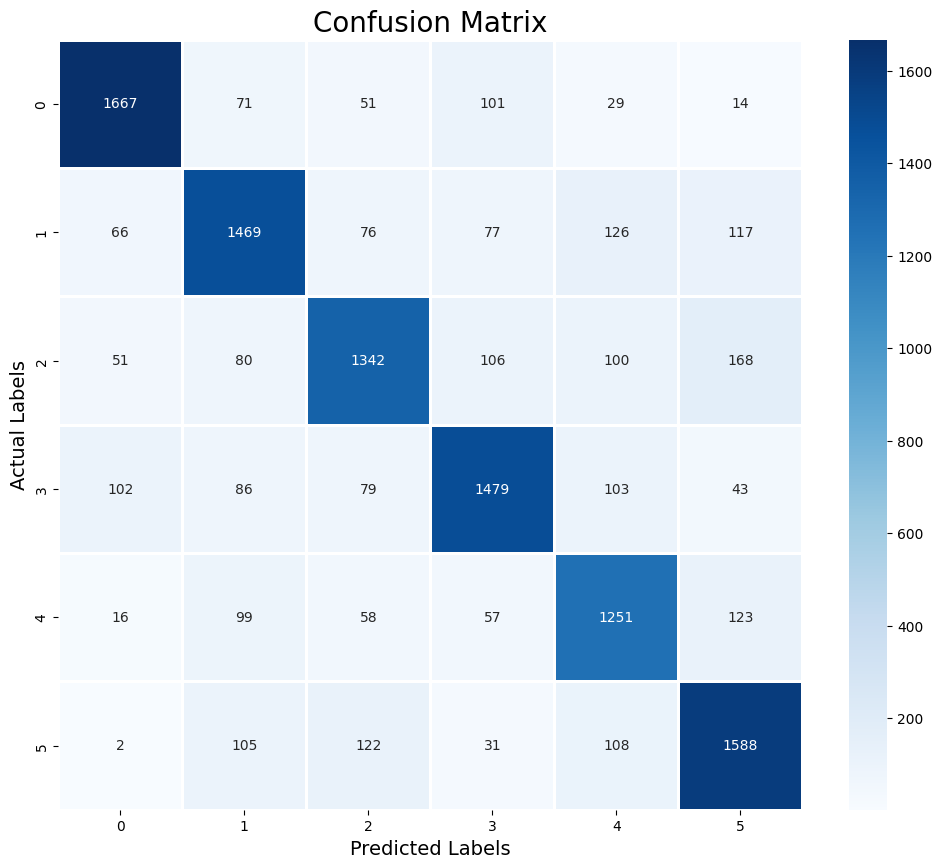

In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[i for i in encoder.categories_])
plt.figure(figsize = (12, 10))

sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [41]:
#Calculating additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import accuracy_score
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


In [42]:
from sklearn.metrics import classification_report # Importing classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       angry       0.88      0.86      0.87      1933
     disgust       0.77      0.76      0.76      1931
        fear       0.78      0.73      0.75      1847
       happy       0.80      0.78      0.79      1892
     neutral       0.73      0.78      0.75      1604
         sad       0.77      0.81      0.79      1956

    accuracy                           0.79     11163
   macro avg       0.79      0.79      0.79     11163
weighted avg       0.79      0.79      0.79     11163



In [43]:

model.save('model.keras')


In [45]:
model_path = 'model.keras'
print(f"The path to your saved model is: {model_path}")


The path to your saved model is: model.keras


In [47]:
from google.colab import files
files.download('model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>